In [1]:
import sys
import pandas as pd
import numpy as np
import nilmtk

sys.path.append('../')
from src.utils import paths_manager as pathsman
from src.unetnilm.data_proc.load_data import pre_proc_ukdale

window = ("2014-06-01", "2014-06-02")
data_type = ("training")
save_path = ('data')

pre_proc_ukdale(data_type, window)

Before Filter 86453
After Filters 86453
1
(12403, 5)
(12403, 5)
12403
12403
12403
12403


In [2]:
import numpy as np
import torch

def spilit_refit_test(data):
    split_1 = int(0.60 * len(data))
    split_2 = int(0.85 * len(data))
    train = data[:split_1]
    validation = data[split_1:split_2]
    test = data[split_2:]
    return train, validation, test

def load_data(data_path, data_type="training", sample=None, data="ukdale", denoise=False):
    print(f"Load {data_type} data")
    if data=="refit":
        x = np.load(data_path+f"/{data}/{data_type}/inputs.npy")
        y = np.load(data_path+f"/{data}/{data_type}/targets.npy")
        z = np.load(data_path+f"/{data}/{data_type}/states.npy")

    else:
        if denoise:
            x = np.load(data_path+f"/{data}/{data_type}/denoise_inputs.npy")
        else:
            x = np.load(data_path+f"/{data}/{data_type}/noise_inputs.npy")
            y = np.load(data_path+f"/{data}/{data_type}/targets.npy")
            z = np.load(data_path+f"/{data}/{data_type}/states.npy")

    if sample is None:
        return x, y, z
    else:
        return x[:sample], y[:sample], z[:sample]
        


class Dataset(torch.utils.data.Dataset):
    def __init__(self,  inputs, targets, states,  seq_len=99):
        self.inputs = inputs
        self.targets = targets
        self.states  = states
        seq_len = seq_len  if seq_len% 2==0 else seq_len+1
        self.seq_len = seq_len
        self.len = self.inputs.shape[0] - self.seq_len
        self.indices = np.arange(self.inputs.shape[0])
    def __len__(self):
        'Denotes the total number of samples'
        return self.len
    
    def get_sample(self, index):
        indices = self.indices[index : index + self.seq_len]
        inds_inputs=sorted(indices[:self.seq_len])
        inds_targs=sorted(indices[self.seq_len-1:self.seq_len])

        return self.inputs[inds_inputs], self.targets[inds_targs], self.states[inds_targs]

    def __getitem__(self, index):
        inputs, target, state = self.get_sample(index)
        return torch.tensor(inputs).unsqueeze(-1).float(), torch.tensor(target).float().squeeze(), torch.tensor(state).long().squeeze()
    

class Seq2PointDataset(torch.utils.data.Dataset):
    def __init__(self,  inputs, targets, states,  seq_len=99):
        self.targets = targets
        self.states  = states
        seq_len = seq_len-1  if seq_len% 2==0 else seq_len
        units_to_pad = seq_len // 2
        new_mains = np.pad(inputs ,(units_to_pad,units_to_pad),'constant',constant_values=(0,0))
        self.inputs  = np.array([new_mains[i:i + seq_len ] for i in range(len(new_mains) - seq_len  + 1)])
        self.len = self.inputs.shape[0] 
        self.indices = np.arange(self.inputs.shape[0])
    def __len__(self):
        'Denotes the total number of samples'
        return self.len
    
    def get_sample(self, index):
        return self.inputs[index], self.targets[index], self.states[index]

    def __getitem__(self, index):
        inputs, target, state = self.get_sample(index)
        return torch.tensor(inputs).unsqueeze(-1).float(), torch.tensor(target).float().squeeze(), torch.tensor(state).long().squeeze()

In [3]:
load_data('data', 'training', None, 'ukdale', False)[0].shape

dset = Dataset(*load_data('data', 'training', None, 'ukdale', False))
dset[2]

Load training data
Load training data


Load training data


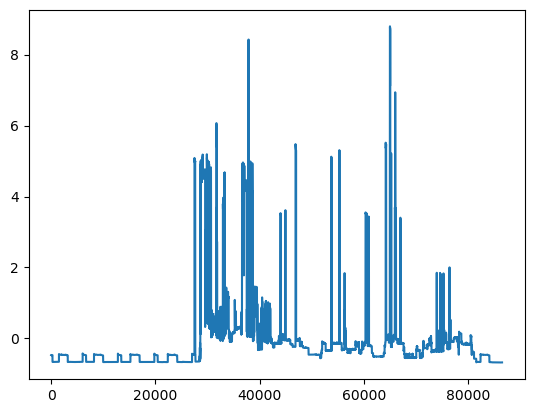

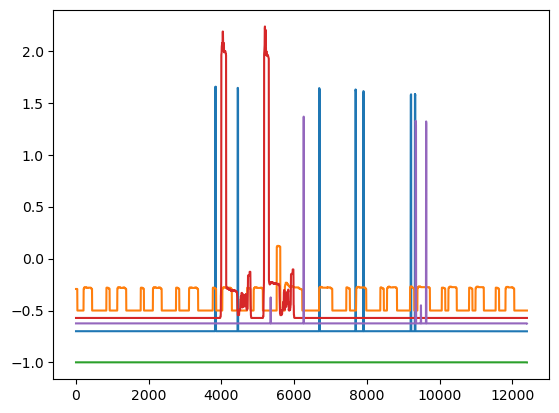

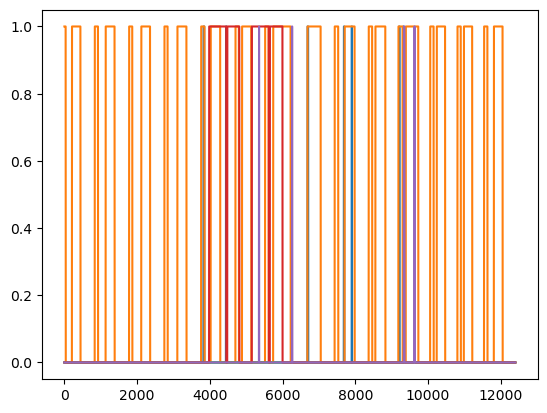

In [4]:
import matplotlib.pyplot as plt

data = load_data('data', 'training', None, 'ukdale', False)

plt.plot(data[0])
plt.show()
plt.plot(data[1])
plt.show()
plt.plot(data[2])
plt.show()

